In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment, DefinedAffine
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, 
                 "char_swap": 0.0, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.4, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.1, "sentence_shuffle": 0.5, "one_third_cut": 0.4, "half_cut":0.1}
preprocess_text = TextAugment([0.0, 0.1, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")

augs_dict = dict(
    grayscale=transforms.Grayscale(num_output_channels=3),
    hflip=transforms.RandomHorizontalFlip(p=1.0),
    rc2=transforms.Compose(
        [transforms.Resize(480),
         transforms.CenterCrop(400)]),
    rotate=DefinedRotation(15),
    affine=DefinedAffine(0, scale=(0.6, 0.6)),
    translate1=DefinedAffine(0, translate=(0.25, 0.25)),
)
im_transform = ImageAugment(count_proba=[0.0, 1.0], augs_dict=augs_dict, choice_probas="uniform")



data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=im_transform, 
                    test_text_transform=None, test_image_transform=None, 
                    train_torchvision_image_transform=transforms.RandomErasing(p=0.5, scale=(0.05, 0.2), ratio=(0.3, 3.3), value=0, inplace=False), 
                    test_torchvision_image_transform=None,
                    cache_images = True, use_images = True, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=True,)



In [3]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-4, weight_decay=1e-6)

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [4]:
batch_size=256
epochs = 25
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([5, 7, 10, 17], gamma=0.1) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()

lr_strategy = {"im_models": {"torchvision_resnet18": {"7": {"lr": optimizer_params["lr"]/750},
                                                      "8": {"lr": optimizer_params["lr"]/250},
                                                      "lr": optimizer_params["lr"]/2000},
                             "torchvision_resnet50_swsl": {"7": {"lr": optimizer_params["lr"]/1000},
                                                           "8": {"lr": optimizer_params["lr"]/500},
                                                           "lr": optimizer_params["lr"]/4000},
                            "lr": optimizer_params["lr"]/4000},
              }

# {"lr": optimizer_params["lr"]/500}



# Image Only

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}

lr_strategy = {
    "im_models": {
        "torchvision_resnet18_ssl": {
            "7": {
                "lr": optimizer_params["lr"] / 200
            },
            "8": {
                "lr": optimizer_params["lr"] / 100
            },
            "lr": optimizer_params["lr"] / 1000
        },
        "lr": optimizer_params["lr"] / 1000
    },
}
model_fn = model_builder(MultiImageMultiTextAttentionEarlyFusionModel,
                         dict(
                             image_models=[{
                                 "model": "torchvision_resnet18_ssl",
                                 "large_rf": True,
                                 "finetune": True
                             }],
                             num_classes=2,
                             text_models=[],
                             internal_dims=256,
                             classifier_dims=256,
                             n_tokens_out=16,
                             n_layers=2,
                             final_layer_builder=fb_1d_loss_builder,
                             gaussian_noise=0.2,
                             dropout=0.2,
                         ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

data["metadata"]["use_images"] = True

multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs

# Detr Model

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}

model_fn = model_builder(
    MultiImageMultiTextAttentionEarlyFusionModel,
    dict(
        image_models=['detr_resnet50'],
        num_classes=2,
        text_models=[
            dict(cls=Fasttext1DCNNModel,
                 params=dict(
                     classifier_dims=256,
                     num_classes=2,
                     n_tokens_out=16,
                     n_layers=2,
                     final_layer_builder=lambda *args: None,
                     gaussian_noise=0.2,
                     dropout=0.2,
                     embedding_dims=256,
                     internal_dims=256,
                     featurizer="cnn",
                 ),
                 in_channels=256,
                 in_tokens=64,
                 forward="get_word_vectors")
        ],
        internal_dims=256,
        classifier_dims=256,
        n_tokens_out=16,
        n_layers=2,
        final_layer_builder=fb_1d_loss_builder,
        gaussian_noise=0.3,
        dropout=0.3,
    ),
    per_param_opts_fn=None,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)

data["metadata"]["use_images"] = True

batch_size=128
epochs = 10
multi_eval = False
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    augmentation_weights=augmentation_weights,
    kfold=kfold,
    multi_eval=multi_eval,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs

# "detr_demo", 'detr_resnet50', 'detr_resnet50_panoptic', 'detr_resnet101', 'detr_resnet101_panoptic', "caption_features"

# Caption Features

In [ ]:
# {"model": "torchvision_resnet18", "large_rf": True, "finetune": True}

model_fn = model_builder(MultiImageMultiTextAttentionEarlyFusionModel, 
                         dict(image_models=['caption_features'], 
                              num_classes=2, 
                              text_models=[dict(cls=Fasttext1DCNNModel, params=dict(classifier_dims=256, 
                                                                                    num_classes=2, n_tokens_out=16,
                                                                                    n_layers=2, final_layer_builder=lambda *args: None,
                                                                                    gaussian_noise=0.2, dropout=0.2, 
                                                                                    embedding_dims=256, internal_dims=256, featurizer="cnn",),
                                               in_channels=256, in_tokens=64, forward="get_word_vectors")],
                              internal_dims=256, classifier_dims=256,
                              n_tokens_out=16, n_layers=2,
                              final_layer_builder=fb_1d_loss_builder,
                              gaussian_noise=0.2, dropout=0.2, ),
                         per_param_opts_fn=None,
                         optimiser_class=optimizer, optimiser_params=optimizer_params)


data["metadata"]["use_images"] = True

multi_eval=False 
kfold=False
results, prfs = train_validate_ntimes(model_fn, data, batch_size, epochs, 
                                      augmentation_weights=augmentation_weights, 
                                      kfold=kfold, multi_eval=multi_eval,
                                      scheduler_init_fn=scheduler_init_fn, 
                                      validation_epochs=[2, 4, 7, 9, 11, 14, 17, 20, 23])
r1, p1 = results, prfs
results
prfs

# "detr_demo", 'detr_resnet50', 'detr_resnet50_panoptic', 'detr_resnet101', 'detr_resnet101_panoptic', "caption_features"



# Multi-Text Multi Image

Doing Special split for FB 
 Train Labels = 0    5040
1    2640
Name: label, dtype: int64 Test Labels = 1    660
0    660
Name: label, dtype: int64



Loading saved model:  resnet18_ssl-contrastive.pth


Autocast =  True Epochs =  10 Divisor = 2 Examples = 3840 Batch Size =  64
Training Samples =  7680 Weighted Sampling =  True Num Batches =  60 Accumulation steps =  4



Epoch =  1 Loss = 0.192216 LR = 0.00003333



Epoch =  2 Loss = 0.167037 LR = 0.00006667



Epoch =  3 Loss = 0.156234 LR = 0.00010000



Epoch =  4 Loss = 0.145396 LR = 0.00009505



Epoch =  5 Loss = 0.129822 LR = 0.00008117



Epoch =  6 Loss = 0.127426 LR = 0.00006113



Epoch =  7 Loss = 0.117785 LR = 0.00003887


Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.329  0.252 0.024 0.965 0.226  0.000 0.000 1.000
1.000  0.552  0.581 0.023 0.975 0.573  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,519,0.406,0.000,1.000,270,0.358,0.000,0.000,1262,0.215,0.000,0.000
1,1142,0.627,1.000,1.000,883,0.257,0.000,0.000,429,0.043,0.000,0.000
2,886,0.134,0.000,1.000,220,0.935,1.000,0.000,88,0.278,0.000,1.000
3,821,0.810,1.000,1.000,1246,0.186,0.000,0.000,1085,0.095,0.000,0.000


scores =  {'map': '0.7154', 'acc': '0.6735', 'auc': '0.7322'}
Epoch =  7 Train = 0.802937 Val = 0.732230



Epoch =  8 Loss = 0.122900 LR = 0.00001883



Epoch =  9 Loss = 0.115112 LR = 0.00000495



Epoch =  10 Loss = 0.111704 LR = 0.00000000



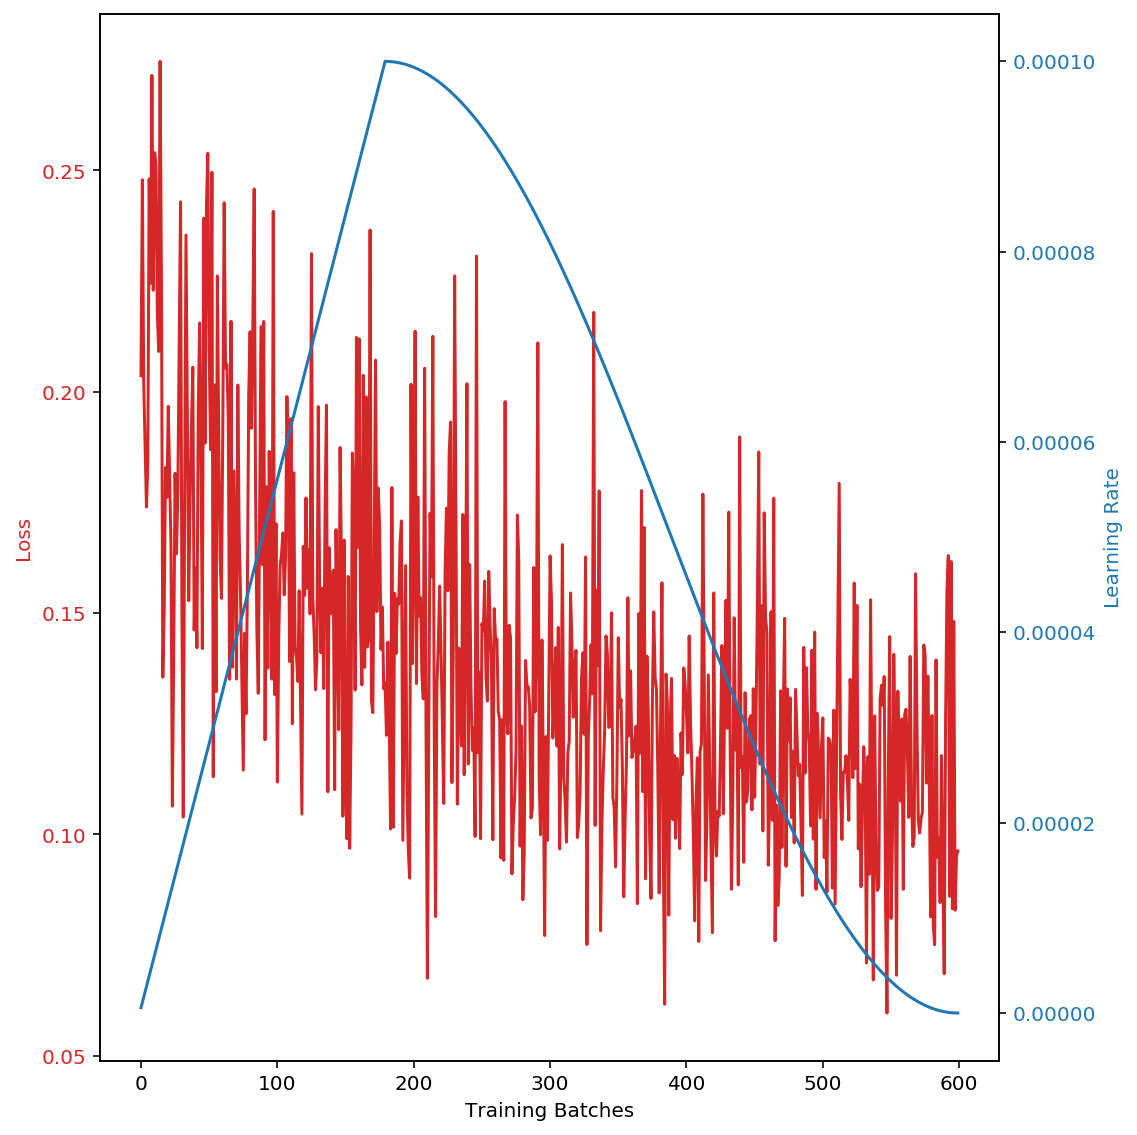

Proba                    Preds                   
        mean median   min   max  mean median   min   max
Labels                                                  
0.000  0.330  0.256 0.024 0.973 0.239  0.000 0.000 1.000
1.000  0.565  0.595 0.024 0.979 0.583  1.000 0.000 1.000

,index,Proba,Preds,Labels,index,Proba,Preds,Labels,index,Proba,Preds,Labels
0,1018,0.120,0.000,0.000,162,0.841,1.000,1.000,291,0.890,1.000,1.000
1,630,0.185,0.000,0.000,780,0.774,1.000,1.000,62,0.358,0.000,1.000
2,904,0.901,1.000,1.000,589,0.415,0.000,1.000,477,0.487,0.000,1.000
3,447,0.376,0.000,1.000,198,0.519,1.000,1.000,354,0.046,0.000,0.000


scores =  {'map': '0.7215', 'acc': '0.6720', 'auc': '0.7365'}


train   val
mean_or_std metric               
mean        map       0.693 0.722
            accuracy  0.757 0.672
            auc       0.815 0.736
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.823  0.803 0.813 5040.000     0.646  0.761 0.699 660.000
pos     0.640  0.669 0.654 2640.000     0.709  0.583 0.640 660.000

In [5]:
lr_strategy = {
    "im_models": {
        "lr": optimizer_params["lr"] / 10,
        "torchvision_resnet18_ssl-contrastive": {
            "lambd": {
                "8": {
                    "finetune": True
                }
            },
            "lr": optimizer_params["lr"] / 10,
            "finetune": False,
        },
        "vgg_face": {
            "lr": optimizer_params["lr"] / 10,
            "lambd": {
                "0": {
                    "feat_extract": {
                        "finetune": True
                    }
                }
            },
            "finetune": False,
        }
    }
}

model_fn = model_builder(
    MultiImageMultiTextAttentionEarlyFusionModel,
    dict(
        image_models=[
            #             {
            #                 "model": 'caption_features',
            #                 "gaussian_noise": 0.0,
            #                 "dropout": 0.0
            #             },
            {
                "model": 'vgg_face',
                "gaussian_noise": 0.0,
                "dropout": 0.0,
            },
            #             {
            #                 "model": 'detr_resnet50',
            #                 "gaussian_noise": 0.0,
            #                 "dropout": 0.0
            #             },
            #             {
            #                 "model": 'detr_resnet50_panoptic',
            #                 "gaussian_noise": 0.0,
            #                 "dropout": 0.0
            #             },
            {
                "model": "torchvision_resnet18_ssl-contrastive",
                "large_rf": True,
                "dropout": 0.0,
                "gaussian_noise": 0.0,
            },
        ],
        num_classes=2,
        text_models=[
            dict(
                cls=Fasttext1DCNNModel,
                params=dict(
                    classifier_dims=256,
                    num_classes=2,
                    n_tokens_in=64,
                    n_tokens_out=16,
                    n_layers=2,
                    final_layer_builder=lambda *args: None,
                    gaussian_noise=0.0,
                    dropout=0.0,
                    embedding_dims=256,
                    internal_dims=256,
                    featurizer="gru",
                ),
                in_channels=256,
                in_tokens=64,
                forward="get_word_vectors",
                dropout=0.2,
                gaussian_noise=0.25,
            ),
            dict(
                cls=AlbertClassifer,
                params=dict(classifier_dims=256,
                            num_classes=2,
                            embedding_dims=768,
                            gaussian_noise=0.0,
                            dropout=0.0,
                            word_masking_proba=0.25,
                            internal_dims=512,
                            final_layer_builder=fb_1d_loss_builder,
                            n_layers=2,
                            n_encoders=2,
                            n_decoders=2,
                            n_tokens_in=96,
                            n_tokens_out=16,
                            featurizer="transformer",
                            model='./distilbert-nsp',
                            finetune=False),
                in_channels=768,
                in_tokens=96,
                forward="get_word_vectors",
                dropout=0.2,
                gaussian_noise=0.25,
            )
        ],
        internal_dims=256,
        classifier_dims=256,
        n_tokens_out=32,
        n_layers=2,
        n_encoders=2,
        n_decoders=2,
        final_layer_builder=fb_1d_loss_builder,
        gaussian_noise=0.75,
        dropout=0.3,  # 0.3
        loss="focal",
        dice_loss_coef=0.0,
        auc_loss_coef=0.0,
    ),
    per_param_opts_fn=lr_strategy,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)

data["metadata"]["use_images"] = True
batch_size = 64
epochs = 5
kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    validation_epochs=[7, 11, 14, 17, 20, 23, 27],
    show_model_stats=False,
    sampling_policy="without_replacement",
    accumulation_steps=4,
    model_call_back=reg_sched,
)
r1, p1 = results, prfs
results
prfs

# 0.824	0.750 (0.761	0.711)

# "detr_demo", 'detr_resnet50', 'detr_resnet50_panoptic', 'detr_resnet101', 'detr_resnet101_panoptic', "caption_features"

# Predict

In [ ]:
batch_size=512
epochs = 1

submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, scheduler_init_fn=scheduler_init_fn)
submission.to_csv("submission.csv",index=False)
submission.sample(3)


In [ ]:
submission.sample(10)